In [1]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_recall_curve,
    classification_report, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
DF_PATH = "../data/dataproject2025_preprocessed_combined.csv"
df = pd.read_csv(DF_PATH)

In [3]:
DROP_FROM_X = [
    "target",
    "Predicted probabilities",
    "Predictions",
    "passthrough__issue_d",        # time — use for split only
    "passthrough__Pct_afro_american",
    "passthrough__zip_code",
]

In [4]:
FEATURES = [c for c in df.columns if c not in DROP_FROM_X]
X = df[FEATURES]
y = df["target"].astype(int)

In [5]:
# Use year from the passthrough column for time split
years = df["passthrough__issue_d"].astype(int)
unique_years = np.array(sorted(years.unique()))
print("Years available:", unique_years)

Years available: [2012 2013 2014 2015 2016 2017 2018 2019 2020]


In [6]:
# Generic rule: train = all but last 2 years; valid = penultimate year; test = last year
if len(unique_years) >= 3:
    train_years = unique_years[:-2]
    valid_years = unique_years[-2:-1]
    test_years  = unique_years[-1:]
else:
    # fallback if fewer than 3 years are present
    train_years = unique_years[:1]
    valid_years = unique_years[1:2]
    test_years  = unique_years[2:3]

print("Train years:", train_years, "Valid year(s):", valid_years, "Test year(s):", test_years)


Train years: [2012 2013 2014 2015 2016 2017 2018] Valid year(s): [2019] Test year(s): [2020]


In [7]:
train_idx = years.isin(train_years)
valid_idx = years.isin(valid_years)
test_idx  = years.isin(test_years)

X_train, y_train = X[train_idx], y[train_idx]
X_valid, y_valid = X[valid_idx], y[valid_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Shapes -> Train:", X_train.shape, y_train.mean(),
      "Valid:", X_valid.shape, y_valid.mean(),
      "Test:",  X_test.shape,  y_test.mean())

Shapes -> Train: (1052038, 31) 0.21190774477727992 Valid: (32368, 31) 0.17613074641621354 Test: (1830, 31) 0.006557377049180328


In [8]:
def evaluate_with_threshold_tuning(model, X_train, y_train, X_valid, y_valid, X_test, y_test, name, proba_from="predict_proba"):
    # Class imbalance weight (for models that need it)
    neg, pos = np.bincount(y_train)
    scale = float(neg / max(pos, 1))

    # Fit
    model.fit(
        X_train.values if hasattr(model, "get_booster") else X_train,  # XGB prefers .values
        y_train.values if hasattr(model, "get_booster") else y_train
    )

    # Probabilities
    if proba_from == "predict_proba":
        p_valid = model.predict_proba(X_valid.values if hasattr(model, "get_booster") else X_valid)[:,1]
        p_test  = model.predict_proba(X_test.values  if hasattr(model, "get_booster") else X_test)[:,1]
    else:  # CatBoost also has predict_proba
        p_valid = model.predict_proba(X_valid)[:,1]
        p_test  = model.predict_proba(X_test)[:,1]

    # 1) default 0.5
    yhat_test_05 = (p_test >= 0.5).astype(int)
    out_05 = dict(
        acc_05 = accuracy_score(y_test, yhat_test_05),
        f1_05  = f1_score(y_test, yhat_test_05),
        auc    = roc_auc_score(y_test, p_test)
    )

    # 2) tune threshold on VALID (maximize F1), then evaluate on TEST
    prec, rec, thr = precision_recall_curve(y_valid, p_valid)
    f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
    best_idx = int(np.argmax(f1s))
    best_thr = float(thr[best_idx]) if best_idx < len(thr) else 0.5
    yhat_test_best = (p_test >= best_thr).astype(int)

    out_best = dict(
        best_thr = best_thr,
        acc_best = accuracy_score(y_test, yhat_test_best),
        f1_best  = f1_score(y_test, yhat_test_best),
        auc      = roc_auc_score(y_test, p_test)  # AUC does not use threshold
    )

    # validation AUC for model selection
    auc_valid = roc_auc_score(y_valid, p_valid)

    return {
        "name": name,
        "auc_valid": auc_valid,
        **{f"test_{k}": v for k, v in out_05.items()},
        **{f"test_{k}": v for k, v in out_best.items()}
    }, model, best_thr

results = []
models = {}

In [9]:
# --- RandomForest (quick baseline)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
res, m, thr = evaluate_with_threshold_tuning(rf, X_train, y_train, X_valid, y_valid, X_test, y_test, name="RandomForest")
results.append(res); models["RandomForest"] = (m, thr)

In [10]:
# --- XGBoost
neg, pos = np.bincount(y_train)
scale = float(neg / max(pos, 1))
xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale,
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    eval_metric="auc"
)
res, m, thr = evaluate_with_threshold_tuning(xgb, X_train, y_train, X_valid, y_valid, X_test, y_test, name="XGBoost")
results.append(res); models["XGBoost"] = (m, thr)

In [11]:
# --- CatBoost
cat = CatBoostClassifier(
    iterations=2000,
    depth=8,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="AUC",
    scale_pos_weight=scale,
    random_seed=42,
    task_type="CPU",
    od_type="Iter",
    od_wait=200,
    verbose=200
)
res, m, thr = evaluate_with_threshold_tuning(cat, X_train, y_train, X_valid, y_valid, X_test, y_test, name="CatBoost", proba_from="predict_proba")
results.append(res); models["CatBoost"] = (m, thr)

0:	total: 309ms	remaining: 10m 17s
200:	total: 32.4s	remaining: 4m 49s
400:	total: 1m 1s	remaining: 4m 3s
600:	total: 1m 29s	remaining: 3m 29s
800:	total: 1m 57s	remaining: 2m 56s
1000:	total: 2m 26s	remaining: 2m 25s
1200:	total: 2m 54s	remaining: 1m 56s
1400:	total: 3m 22s	remaining: 1m 26s
1600:	total: 3m 51s	remaining: 57.7s
1800:	total: 4m 19s	remaining: 28.7s
1999:	total: 4m 49s	remaining: 0us


In [12]:
summary = pd.DataFrame(results).sort_values("auc_valid", ascending=False)
print(summary)

           name  auc_valid  test_acc_05  test_f1_05  test_auc  test_best_thr  \
2      CatBoost   0.711964     0.757923    0.030635  0.677897       0.483162   
1       XGBoost   0.710386     0.742623    0.028866  0.659103       0.520325   
0  RandomForest   0.694571     0.987978    0.083333  0.663504       0.252934   

   test_acc_best  test_f1_best  
2       0.730601      0.027613  
1       0.764481      0.031461  
0       0.691803      0.020833  


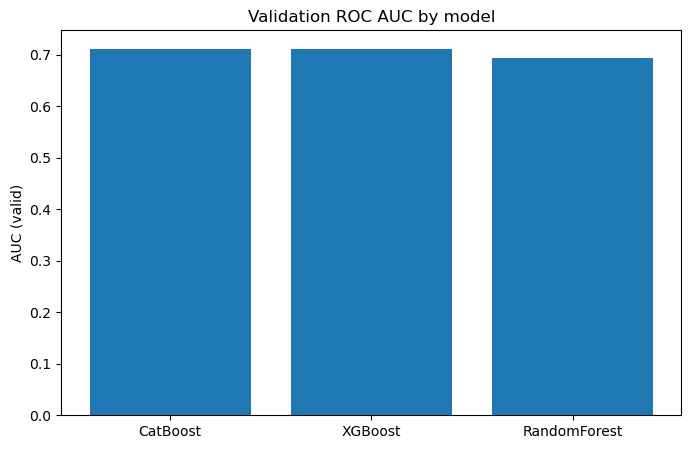

In [13]:
# Plot comparison
plt.figure(figsize=(8,5))
names = summary["name"].tolist()
auc_vals = summary["auc_valid"].tolist()
plt.bar(names, auc_vals)
plt.title("Validation ROC AUC by model")
plt.ylabel("AUC (valid)")
plt.show()


In [14]:
print("Train prevalence:", y_train.mean())
print("Valid prevalence:", y_valid.mean())
print("Test prevalence :", y_test.mean())
print("Train/Valid/Test sizes:", len(y_train), len(y_valid), len(y_test))


Train prevalence: 0.21190774477727992
Valid prevalence: 0.17613074641621354
Test prevalence : 0.006557377049180328
Train/Valid/Test sizes: 1052038 32368 1830


Our previous time split yielded:

Train prevalence ≈ 21%, Valid ≈ 18%, but Test ≈ 0.66% (only ~12 positives in 1,830 cases).

A test set with so few positives makes F1 and accuracy unstable and AUC noisy.
To get a more reliable evaluation, we redefine the split as:

Train = all but the last 3 years

Valid = the penultimate year

Test = the last 2 years combined
This stabilizes the positive rate on the test set while keeping the split strictly chronological (no leakage).

In [15]:
# RE SPLIT

unique_years = np.array(sorted(np.unique(years)))
assert len(unique_years) >= 4, f"Need >=4 years, got {unique_years}"

train_years = unique_years[:-3]
valid_years = unique_years[-3:-2]
test_years  = unique_years[-2:]

train_idx = years.isin(train_years)
valid_idx = years.isin(valid_years)
test_idx  = years.isin(test_years)

X_train, y_train = X[train_idx], y[train_idx]
X_valid, y_valid = X[valid_idx], y[valid_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Years:", unique_years)
print("Train/Valid/Test sizes:", len(y_train), len(y_valid), len(y_test))
print("Prevalence -> Train:", y_train.mean(), "Valid:", y_valid.mean(), "Test:", y_test.mean())

Years: [2012 2013 2014 2015 2016 2017 2018 2019 2020]
Train/Valid/Test sizes: 957145 94893 34198
Prevalence -> Train: 0.20750669961186655 Valid: 0.25629920015174984 Test: 0.1670565530147962


In [16]:
# XGBOOST WITH NEW SPLIT
# class-imbalance weight from TRAIN
neg, pos = np.bincount(y_train)
scale = float(neg / max(pos, 1))

xgb = XGBClassifier(
    n_estimators=800, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=3,
    scale_pos_weight=scale, tree_method="hist", n_jobs=-1,
    random_state=42, eval_metric="auc"
)

xgb.fit(X_train.values, y_train.values,
        eval_set=[(X_valid.values, y_valid.values)], verbose=200)

p_valid = xgb.predict_proba(X_valid.values)[:, 1]
p_test  = xgb.predict_proba(X_test.values)[:, 1]

# tune threshold on VALID (maximize F1), then apply to TEST
prec, rec, thr = precision_recall_curve(y_valid, p_valid)
f1s = 2*(prec*rec)/(prec+rec+1e-12)
best_idx = f1s.argmax()
best_thr = float(thr[best_idx]) if best_idx < len(thr) else 0.5

yhat_05   = (p_test >= 0.5).astype(int)
yhat_best = (p_test >= best_thr).astype(int)

print("XGB valid AUC:", roc_auc_score(y_valid, p_valid))
print("XGB test  AUC:", roc_auc_score(y_test, p_test))
print(f"XGB test @0.5  Acc={accuracy_score(y_test,yhat_05):.3f} F1={f1_score(y_test,yhat_05):.3f}")
print(f"XGB test @{best_thr:.3f} Acc={accuracy_score(y_test,yhat_best):.3f} F1={f1_score(y_test,yhat_best):.3f}")
print("Confusion @best thr:\n", confusion_matrix(y_test, yhat_best))

[0]	validation_0-auc:0.68211
[200]	validation_0-auc:0.71149
[400]	validation_0-auc:0.71472
[600]	validation_0-auc:0.71553
[799]	validation_0-auc:0.71533
XGB valid AUC: 0.715332694906545
XGB test  AUC: 0.7073966322078427
XGB test @0.5  Acc=0.718 F1=0.385
XGB test @0.444 Acc=0.662 F1=0.385
Confusion @best thr:
 [[19020  9465]
 [ 2094  3619]]


In [17]:
# CATBOOST WITH NEW SPLIT

cb = CatBoostClassifier(
    iterations=2000, depth=8, learning_rate=0.05, l2_leaf_reg=5,
    loss_function="Logloss", eval_metric="AUC",
    scale_pos_weight=scale, random_seed=42,
    task_type="CPU", od_type="Iter", od_wait=200, verbose=False
)

cb.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True, verbose=False)

p_valid = cb.predict_proba(X_valid)[:, 1]
p_test  = cb.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_valid, p_valid)
f1s = 2*(prec*rec)/(prec+rec+1e-12)
best_idx = f1s.argmax()
best_thr = float(thr[best_idx]) if best_idx < len(thr) else 0.5

yhat_05   = (p_test >= 0.5).astype(int)
yhat_best = (p_test >= best_thr).astype(int)

print("Cat valid AUC:", roc_auc_score(y_valid, p_valid))
print("Cat test  AUC:", roc_auc_score(y_test, p_test))
print(f"Cat test @0.5  Acc={accuracy_score(y_test,yhat_05):.3f} F1={f1_score(y_test,yhat_05):.3f}")
print(f"Cat test @{best_thr:.3f} Acc={accuracy_score(y_test,yhat_best):.3f} F1={f1_score(y_test,yhat_best):.3f}")
print("Confusion @best thr:\n", confusion_matrix(y_test, yhat_best))

Cat valid AUC: 0.7160191017007935
Cat test  AUC: 0.7098773799495443
Cat test @0.5  Acc=0.723 F1=0.385
Cat test @0.445 Acc=0.668 F1=0.387
Confusion @best thr:
 [[19250  9235]
 [ 2125  3588]]


In [18]:
# SAVE MODEL (pkl)
import joblib, os
os.makedirs("../models", exist_ok=True)

MODEL_PATH = "../models/step2_catboost_timesplit.pkl"
joblib.dump(cb, MODEL_PATH)
print("Saved:", MODEL_PATH)


Saved: ../models/step2_catboost_timesplit.pkl


In [19]:
# Compute probabilities on the whole dataset
proba_all = cb.predict_proba(X)[:, 1]

# Show the first few probabilities
pd.DataFrame({
    "Predicted probabilities": proba_all
}).head(20)

,Predicted probabilities
0,0.249833
1,0.296148
2,0.124307
3,0.180381
4,0.607789
5,0.455362
6,0.801648
7,0.396108
8,0.478703
9,0.238568


In [22]:
import joblib
import pandas as pd

# Compute probabilities
proba_all = cb.predict_proba(X)[:, 1]

# Create a DataFrame (optional but nice for readability)
proba_df = pd.DataFrame({"Predicted probabilities": proba_all})

# Save to a pkl file
joblib.dump(proba_df, "../models/predicted_probabilities.pkl")


['../models/predicted_probabilities.pkl']

In [20]:
# save other necessary variables in pkl file
# Save them in pkl file
os.makedirs("../models", exist_ok=True)

dict_var = {"X_test" : X_test, "y_test" : y_test, "y_pred_test" : yhat_05, "y_proba" : p_test}
MODEL_PATH = "../models/needed_variables.pkl"
joblib.dump(dict_var, MODEL_PATH)
print("Saved:", MODEL_PATH)

Saved: ../models/needed_variables.pkl


In [21]:
# save other necessary variables in pkl file
# Save them in pkl file
os.makedirs("../models", exist_ok=True)

dict_var = { "X_train" : X_train, "y_train" : y_train}
MODEL_PATH = "../models/needed_variables2.pkl"
joblib.dump(dict_var, MODEL_PATH)
print("Saved:", MODEL_PATH)

Saved: ../models/needed_variables2.pkl
